# Data wrangling of the Quotebank dataset

This notebook is dedicated to developpe the datawrangling methods that will be used to clean the full Quotebank dataset used in our project. The methods are tested on a sample of the full database.

The sample is made frome 200'000 quotes of each years of interest (2015-2020) which should therefore contain $1.2 \cdot 10^6$ entries.

The script will proceed through the following steps:
  - drop of the duplicates
  - drop of the quotes for which the speaker is not identified (threshold to be defined)
  - drop the quotes in which the probability between one or more speaker his near each other (threshold to be defined)
  - drop of any quotes that is empty
  - keep only the speaker that has the most probability of being the author of the quote
    

TODO:
 - analyser NumOccurences
 - analyser longueur des Quotes
 - analyser None selon année

In [3]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(10,7)})

Quick look at the raw data:

In [5]:
%%time
#copy the path of the sample quotes: (to big to put in the git)
#ALEX: 'C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/'
#JULES: ...
#MARIN: ...
#NICO: ...


path_2_data = 'C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/'


#import the dataset sample
raw_data = pd.read_json(path_2_data + 'Sample.json.bz2',compression="bz2",lines=True)

raw_data.describe()

Wall time: 1min 4s


,numOccurrences
count,1.263790e+06
mean,3.767778e+00
std,4.666187e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.300000e+04


In [6]:
raw_data.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
1151416,2020-01-28-080483,"The message was clear, and oh so Kobe: No merc...",David Axelrod,"[Q1251914, Q519838]",2020-01-28 23:43:26,2,"[[David Axelrod, 0.403], [None, 0.3971], [Dere...",[https://people.com/politics/kobe-bryant-never...,E
1148683,2020-01-03-012157,"Dude, its not always going to be seeing stars ...",Philip Ellis,"[Q11332472, Q3378998]",2020-01-03 15:28:04,1,"[[Philip Ellis, 0.5532], [None, 0.4468]]",[https://www.pulse.com.gh/lifestyle/mens-healt...,E
646252,2018-05-21-041125,I would say I made the Olympic team on pure wi...,Ariana Kukors,[Q265724],2018-05-21 10:00:02,2,"[[Ariana Kukors, 0.6161], [None, 0.2855], [Fra...",[https://www.presstelegram.com/2018/05/21/aria...,E


Test to see if the ids are unique within the dataset

In [7]:
%%time
#Keeping the first occurence of the duplicates
size_bf = raw_data.shape[0]
df = raw_data.copy().drop_duplicates(subset = 'quoteID', keep='first')
size_af = df.shape[0]

print('{} dupplicates rows have been removed'.format(size_bf-size_af))
print('Unique rows in the data set:', df.quoteID.is_unique)

0 dupplicates rows have been removed
Unique rows in the data set: True
Wall time: 1.33 s


Sample of the sample to speed up calculation while implementing

In [30]:
df_test = df[0:430000]


#Problem at 4307769

Extraction the probabilities linked to the two most probable speakers

In [32]:
%%time
#highest probability
df_thres = df_test.copy()
df_thres['p1'] = [i[0][1] for i in df_test['probas']]
df_thres['p1'] = df_thres['p1'].astype(float)

#second highest probability
df_thres['p2'] = [i[1][1] for i in df_test['probas']]
df_thres['p2'] = df_thres['p2'].astype(float)

#difference between the two above
df_thres['delta_p'] = df_thres['p1']-df_thres['p2']

#extracting the date
df_thres['year'] = pd.DatetimeIndex(df_thres['date']).year



Wall time: 797 ms


Boxplot to analyze the presence of outliers, it seems that there is some problematic values:
 - p2 should be always smaller than 0.5 (otherwise it should be p1)
 - p1 - p2 should be always positive since p1>p2
 - low values in p1 should be removed

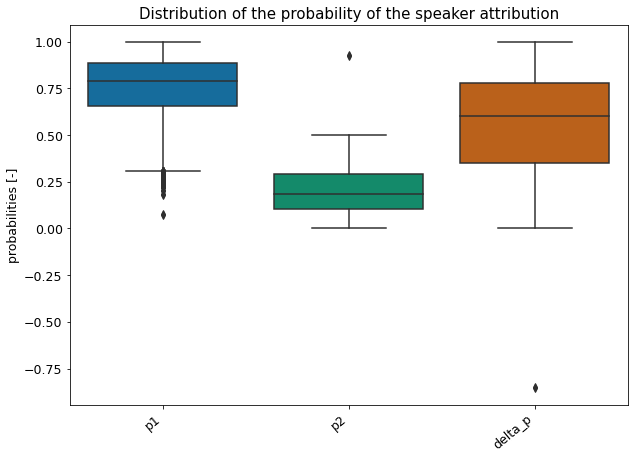

In [33]:
#boxplot to analyze the presence of outliers
data_plot = df_thres.drop(['numOccurrences','year'], axis = 1)
ax = sns.boxplot(data = data_plot)
ax.set(ylabel='probabilities [-]')
ax.set_title('Distribution of the probability of the speaker attribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

Distribution in the forms of histograms, observation:
 - Strange drop in the distribution of p1 around x = 0.5

(-0.1, 1.1)

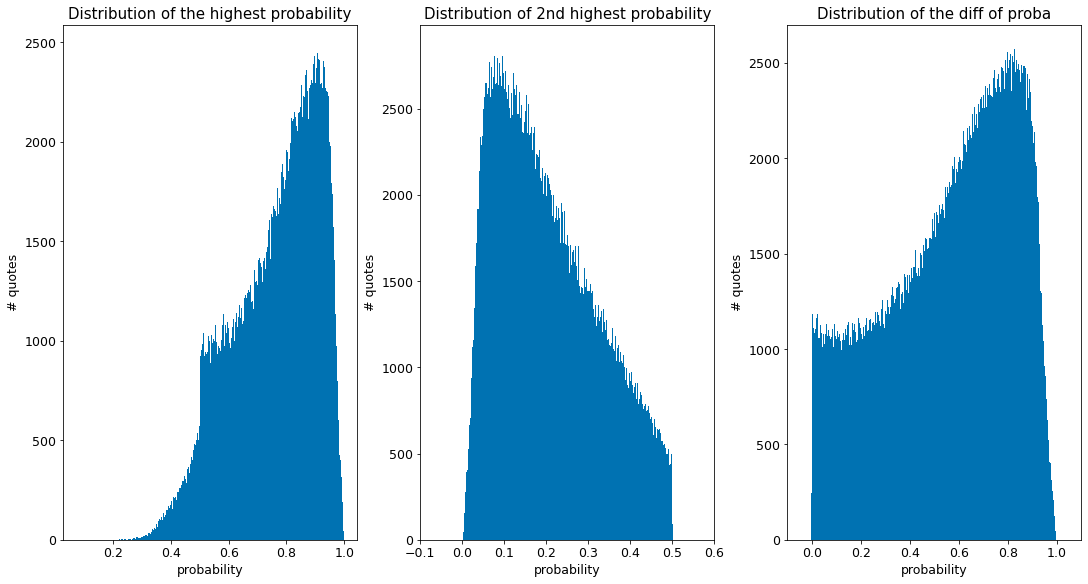

In [34]:
#histograms to better understand the distribution of the data
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15, 8))
ax[0].hist(df_thres.p1, bins=500)
ax[0].set_title('Distribution of the highest probability')
ax[0].set_ylabel('# quotes')
ax[0].set_xlabel('probability')
#ax[0].set_xlim([-10000,600000])
#ax[0].set_ylim([0,340])

ax[1].hist(df_thres.p2, bins=500)
ax[1].set_title('Distribution of 2nd highest probability')
ax[1].set_ylabel('# quotes')
ax[1].set_xlabel('probability')
ax[1].set_xlim([-0.1,0.6])
#ax[1].set_ylim([0,340])

ax[2].hist(df_thres.delta_p, bins=500)
ax[2].set_title('Distribution of the diff of proba')
ax[2].set_ylabel('# quotes')
ax[2].set_xlabel('probability')
ax[2].set_xlim([-0.1,1.1])
#ax[2].set_ylim([0,340])

After the anlysis above we can drop the quotes for which the speaker
   - have meaningless probabilities
   - is not clearly identified (threshold to be defined: *threshold_min*)
   - is probably confused with another speaker (threshold to be defined: *threshold_diff*)
   - is not identified (None values)

In [35]:
#fixing the threshold (=> to low percentage of attribution to be considered in the analysis)
threshold_min = 0.5
threshold_diff = 0.3

#removing the rows that not pass the criterions
indexNames = df_thres[
                        (df_thres['p1'] < threshold_min)
                      | (df_thres['delta_p'] < threshold_diff)
                      | (df_thres['speaker'] == 'None')
                                                                          ].index

df_thres = df_thres.drop(indexNames , inplace=False)

#check of the number of deleted rows
print('Min Threshold set at ',threshold_min)
print('Diff Threshold set at ',threshold_diff)
print('----------------------')
print('Due to the above threshold, {} rows have been removed'.format(len(indexNames)))
print(' - {} x None value for speaker'.format(df_test['speaker'].value_counts()['None']))
print(' - {} x threshold probabilities not reached'.format(len(indexNames)-df_test['speaker'].value_counts()['None']))

Min Threshold set at  0.5
Diff Threshold set at  0.3
----------------------
Due to the above threshold, 200739 rows have been removed
 - 145817 x None value for speaker
 - 54922 x threshold probabilities not reached


Again some plots to see if the dataWrangling is efficient

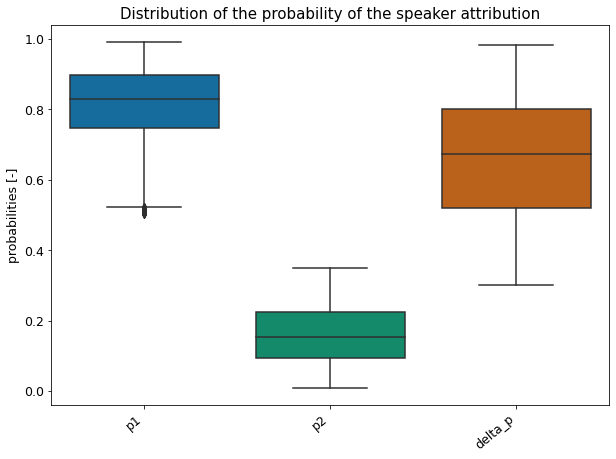

In [36]:
#boxplot to analyze the presence of outliers
data_plot = df_thres.drop(['numOccurrences','year'], axis = 1)
ax = sns.boxplot(data = data_plot)
ax.set(ylabel='probabilities [-]')
ax.set_title('Distribution of the probability of the speaker attribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

Text(0.5, 0, 'probability')

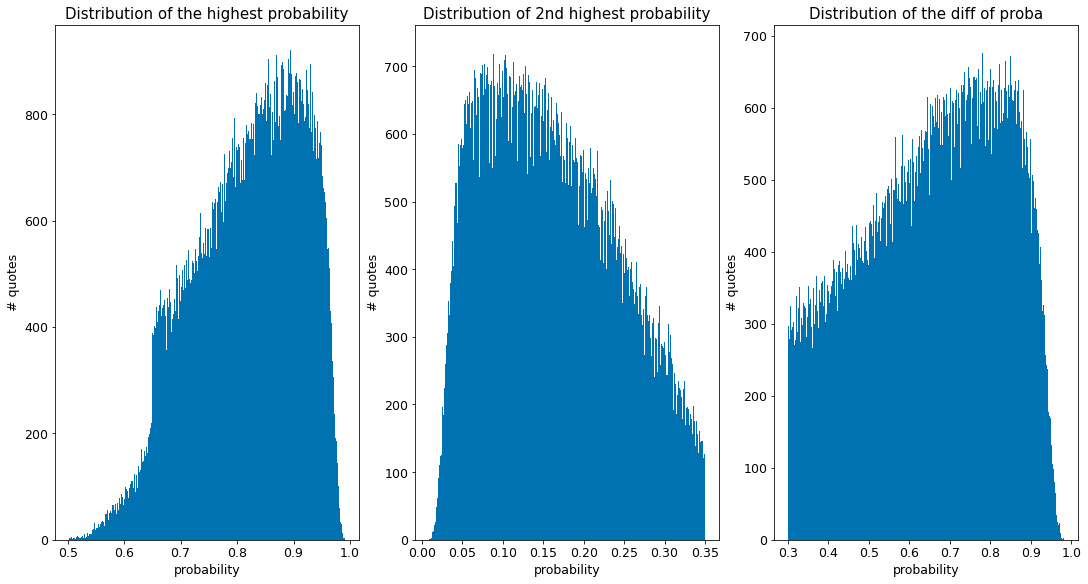

In [37]:
#histograms to better understand the distribution of the data
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15, 8))
ax[0].hist(df_thres.p1, bins=500)
ax[0].set_title('Distribution of the highest probability')
ax[0].set_ylabel('# quotes')
ax[0].set_xlabel('probability')
#ax[0].set_xlim([-10000,600000])
#ax[0].set_ylim([0,340])

ax[1].hist(df_thres.p2, bins=500)
ax[1].set_title('Distribution of 2nd highest probability')
ax[1].set_ylabel('# quotes')
ax[1].set_xlabel('probability')
#ax[1].set_xlim([-10000,600000])
#ax[1].set_ylim([0,340])

ax[2].hist(df_thres.delta_p, bins=500)
ax[2].set_title('Distribution of the diff of proba')
ax[2].set_ylabel('# quotes')
ax[2].set_xlabel('probability')
#ax[2].set_xlim([-10000,600000])
#ax[2].set_ylim([0,340])

In [38]:
df_thres.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,p1,p2,delta_p,year
0,2015-11-11-109291,They'll call me lots of different things. Libe...,Chris Christie,[Q63879],2015-11-11 00:55:12,1,"[[Chris Christie, 0.7395], [Bobby Jindal, 0.15...",[http://thehill.com/blogs/ballot-box/259760-ch...,E,0.7395,0.1505,0.5890,2015
2,2015-09-11-070666,It's kind of the same way it's been with the R...,Niklas Kronwall,[Q722939],2015-09-11 19:54:00,1,"[[Niklas Kronwall, 0.7119], [None, 0.2067], [H...",[http://redwings.nhl.com/club/news.htm?id=7787...,E,0.7119,0.2067,0.5052,2015
4,2015-11-09-033345,I had a chuckle: They were showing a video of ...,Kris Draper,[Q948695],2015-11-09 00:57:45,3,"[[Kris Draper, 0.8782], [None, 0.1043], [Serge...",[http://ca.rd.yahoo.com/sports/rss/nfl/SIG=13u...,E,0.8782,0.1043,0.7739,2015
5,2015-09-05-038628,New Zealand will go in with a lot of confidenc...,John Eales,[Q926351],2015-09-05 02:40:10,3,"[[John Eales, 0.7896], [None, 0.2006], [Toutai...",[http://www.stuff.co.nz/sport/rugby/all-blacks...,E,0.7896,0.2006,0.5890,2015
8,2015-02-11-042325,In his suicide note he even made a joke thanki...,Pat Buckley,"[Q19956564, Q23006312, Q7143252, Q7143253]",2015-02-11 09:59:09,1,"[[Pat Buckley, 0.8816], [None, 0.1184]]",[http://independent.ie/life/health-wellbeing/m...,E,0.8816,0.1184,0.7632,2015


In [39]:
df_thres.to_json(f"C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/Sample_cleaned_400000.json.bz2",compression="bz2",lines=True,orient="records")
print("Comme dirait Marin, tout est bien qui finit bien")

Comme dirait Marin, tout est bien qui finit bien
